In [53]:
import torch
import torch.optim as optim
import math
import pandas as pd
from torch.utils import data

In [54]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

1. Exploring optimisation of analytic functions


In [55]:
def rastriginfunction(x, A):
  return 2 * A + x[0].pow(2) - (A * torch.cos(2 * math.pi * x[0])) + x[1].pow(2) - (A * torch.cos(2 * math.pi * x[1]))

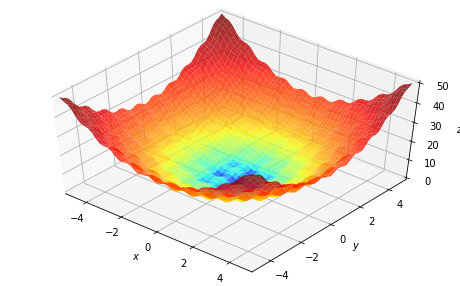

In [56]:
xmin, xmax, xstep = -5, 5, .2
ymin, ymax, ystep = -5, 5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = rastriginfunction(torch.tensor([x, y]), 1).numpy()

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)
ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [57]:
def opti(p, opt_rf):
  path = np.empty((2,0))
  path = np.append(path, p.data.numpy(), axis=1)

  for i in range(100):
    opt_rf.zero_grad()
    output = rastriginfunction(p, 1)
    output.backward()
    opt_rf.step()
    path = np.append(path, p.data.numpy(), axis=1)
  return path

In [58]:
# SGD optimiser
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opt_rf_sgd = optim.SGD([p], lr=0.01)
path_sgd = opti(p, opt_rf_sgd)

# SGD + Momentum Optimiser
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opt_rf_sgd_mom = optim.SGD([p], lr = 0.01, momentum=0.9)
path_sgd_mom = opti(p, opt_rf_sgd_mom)

# Adagrad Optimiser
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opt_rf_adagrad = optim.Adagrad([p], lr = 0.01)
path_adagrad = opti(p, opt_rf_adagrad)

# Adam Optimiser
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opt_rf_adam = optim.Adam([p], lr = 0.01)
path_adam = opti(p, opt_rf_adam)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Log scale: values of z <= 0 have been masked
  


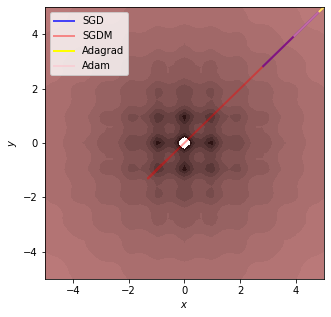

In [59]:
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.pink)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.plot(path_sgd[0], path_sgd[1], color='blue', label='SGD', linewidth=2, alpha = 0.7)
ax.legend()

ax.plot(path_sgd_mom[0], path_sgd_mom[1], color='red', label='SGDM', linewidth=2, alpha = 0.4)
ax.legend()

ax.plot(path_adagrad[0], path_adagrad[1], color='yellow', label='Adagrad', linewidth=2)
ax.legend()

ax.plot(path_adam[0], path_adam[1], color='pink', label='Adam', linewidth=2, alpha = 0.5)
ax.legend()

Text(0, 0.5, 'Fuction Value')

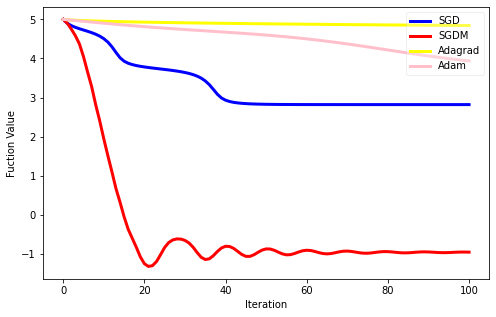

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

plt.plot(path_sgd[0], color='blue', label='SGD', linewidth=3)
plt.plot(path_sgd_mom[0], color='red', label='SGDM', linewidth=3)
plt.plot(path_adagrad[0], color='yellow', label='Adagrad', linewidth=3)
plt.plot(path_adam[0], color='pink', label='Adam', linewidth=3)

ax.legend(loc=1, fancybox=True, framealpha=0.3)

ax.set_xlabel('Iteration')
ax.set_ylabel('Fuction Value')

2. Optimisation of a SVM on real data


In [61]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)
df = df.sample(frac=1,random_state=0) #shuffle

df = df[df[4].isin(['Iris-virginica','Iris-versicolor'])] #filter

#addlabelindicescolumn
mapping = {k: v for v,k in enumerate(df[4].unique())}
df[5] = (2 * df[4].map(mapping)) - 1 #labelsin{−1,1}

#normalisedata
alldata = torch.tensor(df.iloc[:,[0,1,2,3]].values,dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0))/alldata.var(dim=0)

#createdatasets
targetstr = torch.tensor(df.iloc[:75,5].values,dtype=torch.long)
targetsva = torch.tensor(df.iloc[75:,5].values,dtype=torch.long)
datatr = alldata[:75]
datava = alldata[75:]


In [62]:
# Defining hinge loss

def hinge_loss(y_pred, y_true):
    return torch.mean(torch.clamp(1-y_true.mul(y_pred), min = 0))

In [63]:
# Defining SVM

def svm(x, w, b):
    h = (w*x).sum(1) + b
    return h

In [64]:
# Creating dataset and dataloader

dataset = data.TensorDataset(datatr,targetstr) 
dataloader = data.DataLoader(dataset, batch_size=25) 

In [75]:
# Function for training the model
def train_model(w, b, opt):
  for epoch in range(100):
    train_loss = 0
    val_loss = 0
    for batch in dataloader:
      opt.zero_grad()
      output = hinge_loss(svm(batch[0], w, b), batch[1])
      output.backward()
      opt.step()
      train_loss += output
  return w, b

# Function for validating the model
def validate_model(w, b):
  epoch_acc = np.empty(100)
  for epoch in range(100): 
    right_val = 0
    for i in range(len(targetsva)):
      val_pred = svm(datava[i], w, b)
      val_pred[val_pred < 0] = -1
      val_pred[val_pred > 0] = 1
      if val_pred == targetsva[i] :
        right_val += 1
      epoch_acc[epoch] = right_val/len(targetsva)
  return epoch_acc

In [79]:
# Accuracy using SGD Optimiser

w_sgd = torch.rand(1, datatr.shape[1], requires_grad = True)
b_sgd = torch.rand(1, requires_grad = True)

opt_sgd = optim.SGD([w_sgd,b_sgd], lr = 0.01, weight_decay=0.0001)
w_sgd, b_sgd = train_model(w_sgd, b_sgd, opt_sgd)

sgd_accuracy = validate_model(w_sgd, b_sgd).mean()
print("Accuracy for SGD Optimiser: %.2f" %sgd_accuracy)

Accuracy for SGD Optimiser: 0.96


In [81]:
# Accuracy for Adam Optimiser

w_adam = torch.rand(1, datatr.shape[1], requires_grad = True)
b_adam = torch.rand(1, requires_grad = True)

opt_adam = optim.Adam([w_adam,b_adam], lr = 0.01, weight_decay=0.0001)
w_adam, b_adam = train_model(w_adam, b_adam, opt_adam)

adam_accuracy = validate_model(w_adam, b_adam).mean()
print("Accuracy for Adam Optimiser: %.2f" %adam_accuracy)

Accuracy for Adam Optimiser: 0.88
